# Genotype data reformat

**FIXME: should iclude both data format conversion and region extraction for genotypes**

This is the plink 2 vcf part of data processing pipeline for xqtl workflow, containing the generation of:
. vcf genome type file

This notebook take care of the dark yellow part of the following graph


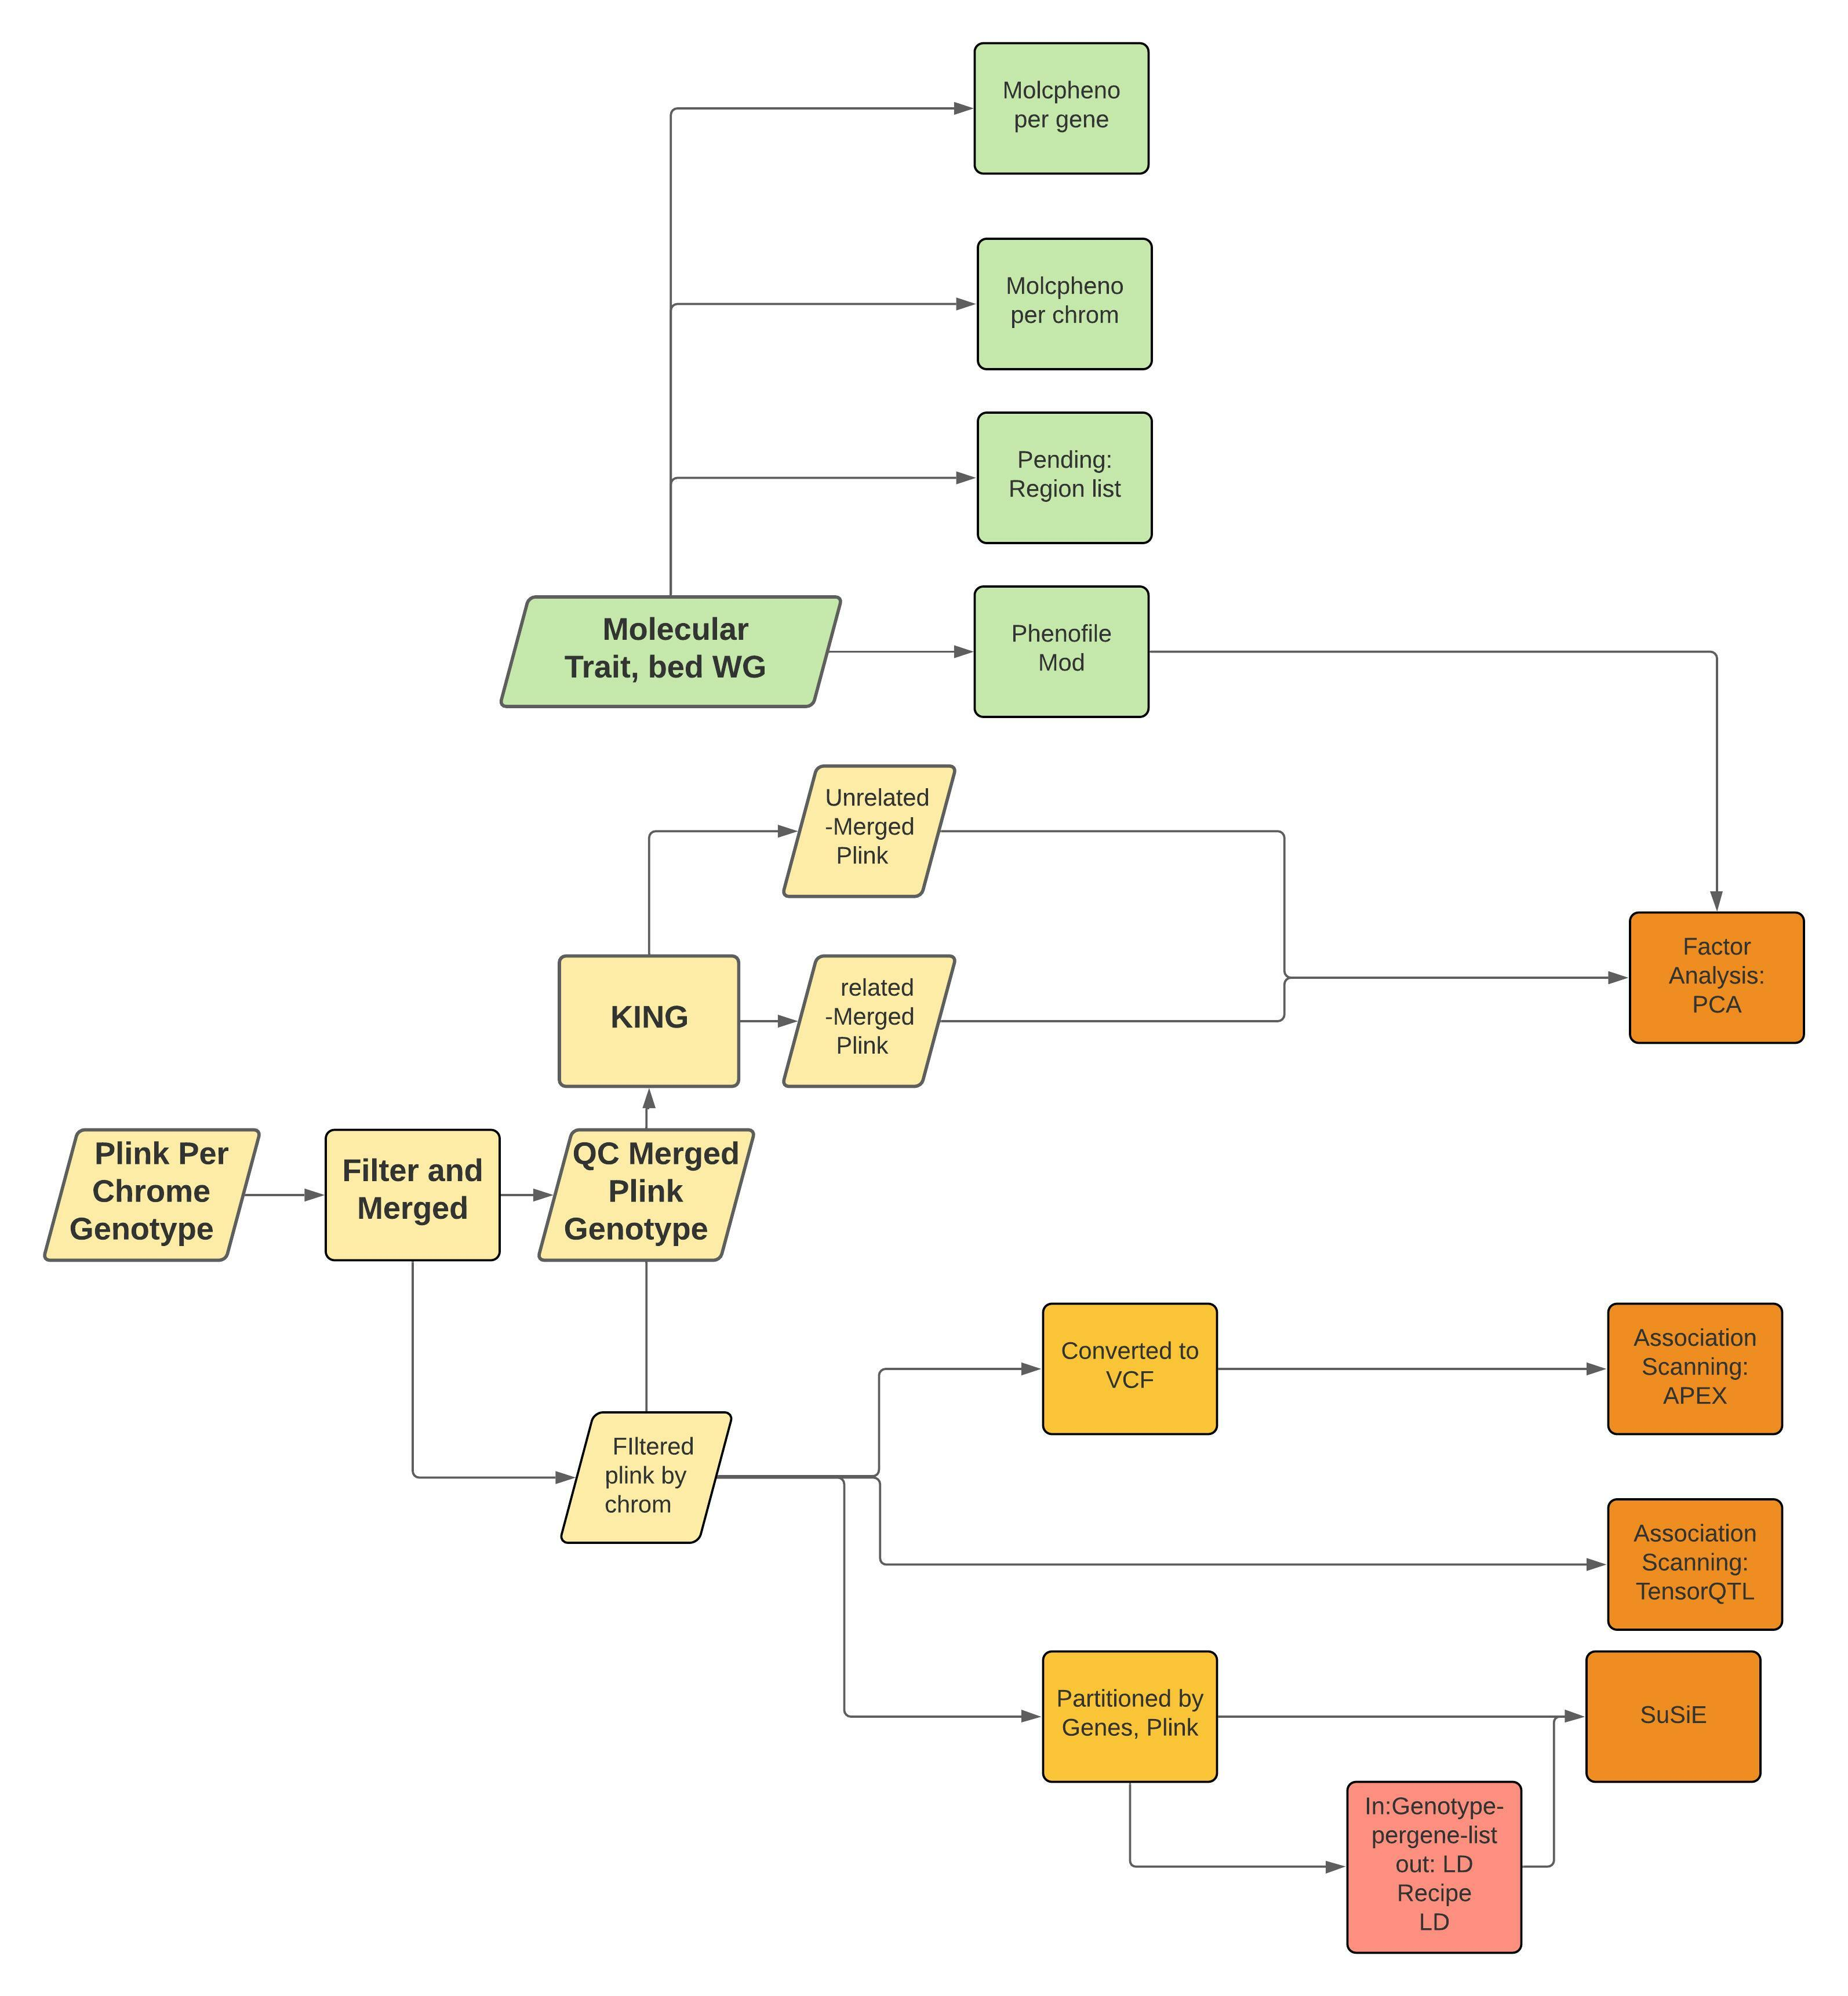




### Input
The input for this workflow is the collection of data for 1 conditions as described in the readme of this git repo
1. 1 collection of genotype data in plink format, partitioned by chrm
2. A list of genotype file documenting the location of 1.



1. A single Whole genome data in VCF format, or in PLINK bim/bed/fam bundle; Or,
2. A list of per chromosome VCF or PLINK data (without suffix)



### Output
For each collection, the output is 23 sets of :
1. genotype file in compress vcf format
2. tbi index for the compressed vcf



In [2]:
[global]
import os
# Work directory & output directory
parameter: cwd = path
# The filename name for containers
parameter: container = ''
# File prefix for the analysis output
parameter: name = str
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 20
# the path to bed file for a merged, whole genomoe, Genotype file in plink trio format
parameter: genoFile = path
# Cis Windows
parameter: window = 500000

# Get the unique chormosome that have regions to be analyzed.
def extract(lst):
    return [item[0] for item in lst]

import os


# FIXME: think of input: be a file of regions?
# Move away from global statement
parameter: region_list = ''

if region_list:
    regions = [x.strip().split() for x in open(region_list).readlines() if x.strip() and not x.strip().startswith('#')]
    chrom = list(set(extract(regions)))
if not container:
    container = None
# use this function to edit memory string for PLINK input
from sos.utils import expand_size
cwd = f"{cwd:a}"
# FIXME: For compatibility before I change everyting to `cwd`
wd = cwd

### Plink to VCF transformation


In [ ]:
[plink2vcf_1]
input: genoFile, for_each = "chrom"
output: f'{wd:a}/{name}_per_chrom_vcf/{name}_chr{_chrom}.vcf.gz',
        f'{wd:a}/{name}_per_chrom_vcf/{name}_chr{_chrom}.vcf.gz.tbi'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genoFile:ad}:{genoFile:ad}']
    plink --bfile $[genoFile:n] \
    --recode vcf-iid       --out $[_output[0]:nn] --chr $[_chrom]
    bgzip $[_output[0]:n]  
    tabix -f -p vcf $[_output[0]]

In [ ]:
[plink2vcf_2]
input: group_by = "all"
output: f'{wd:a}/{name}_per_chrom_vcf/{name}.vcf_chrom_list.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genoFile:ad}:{genoFile:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    chrom = c($[",".join(chrom)])
    dir = "$[_output:nn]"
    geno_list = tibble(`#chr` = chrom, dir = map_chr(`#chr`,~paste(c(dir,"_chr",.x,".vcf.gz"),collapse ="")))%>%arrange(`#chr`)
    geno_list%>%write_delim("$[_output]","\t")

### Partition Plink by genes


In [ ]:
[plink_by_gene_1]
input: genoFile,  for_each = 'regions'
output: f'{wd:a}/{name}_per_gene_plink/{_regions[3]}.bed'

task: trunk_workers = 1, trunk_size = job_size, walltime = '12h',  mem = '6G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genoFile:ad}:{genoFile:ad}']
    ##### Get the locus genotypes for $[_regions[3]]
    plink --bfile $[genoFile:an] \
    --make-bed \
    --out $[_output[0]:n] \
    --chr $[_regions[0]] \
    --from-bp $[f'1' if (int(_regions[1]) - window) < 0 else f'{(int(_regions[1]) - window)}'] \
    --to-bp $[int(_regions[2]) + window ] \
    --allow-no-sex || true
    
    touch $[_output]

In [ ]:
[plink_by_gene_2]
input: group_by = "all"
output: f'{wd:a}/{name}_per_gene_plink/{name}.plink_gene_list.txt'
import pandas as pd
df = pd.DataFrame({"region" : [x[3] for x in regions] ,"dir" : _input})
df.to_csv(_output,sep = "\t",index = 0)

### Partition Plink by Chrom


In [ ]:
[plink_by_chrom_1]
input: genoFile, for_each = "chrom"
output: f'{wd:a}/{name}_per_chrom_plink/{name}_chr{_chrom}.bed'
# look up for genotype file
task: trunk_workers = 1, trunk_size = job_size, walltime = '12h',  mem = '6G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genoFile:ad}:{genoFile:ad}']
    ##### Get the locus genotypes for $[_chrom]
    plink --bfile $[_input:an] \
    --make-bed \
    --out $[_output[0]:n] \
    --chr $[_chrom[0]] \
    --allow-no-sex || true

In [ ]:
[plink_by_chrom_2]
input: group_by = "all"
output: f'{wd:a}/{name}_per_chrom_plink/{name}.plink_chrom_list.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genoFile:ad}:{genoFile:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    chrom = c($[",".join(chrom)])
    dir = "$[_output:nn]"
    geno_list = tibble(`#chr` = chrom, dir = map_chr(`#chr`,~paste(c(dir,"_chr",.x,".bed"),collapse ="")))%>%arrange(`#chr`)
    geno_list%>%write_delim("$[_output]","\t")

## Merge plink files

In [ ]:
[merge_plink]
# Input is a list of PLINK bed files
parameter: genoFile = paths
skip_if(len(genoFile) == 1)
input: genoFile, group_by = 'all'
output: f"{cwd}/{name}.bed"
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
with open(f'{_output:n}.merge_list', 'w') as f:
    f.write('\n'.join([str(f'{x:n}') for x in _input[1:]]))

bash: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    plink \
    --bfile ${_input[0]:n} \
    --merge-list ${_output:n}.merge_list \
    --make-bed \
    --out ${_output:n} \
    --threads ${numThreads} \
    --memory ${int(expand_size(mem) * 0.9)/1e06}

In [ ]:
import pandas as pd
parameter: genotype_list = path
geno_file_inv = pd.read_csv(genotype_list, sep = "\t")
genoFile = geno_file_inv["dir"].values.tolist()